<a href="https://colab.research.google.com/github/Iamsdt/UdacityPyTorch/blob/master/src/notebook/MLP_Validation3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x57c56000 @  0x7f6f759f62a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
import torch
from torch import nn, optim
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

from torchvision import datasets, transforms

import helper

In [0]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(50176, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 128)
        self.layer5 = nn.Linear(128, 10)
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.layer1(x)))
        x = self.dropout(F.relu(self.layer2(x)))
        x = self.dropout(F.relu(self.layer3(x)))
        x = self.dropout(F.relu(self.layer4(x)))

        # output so no dropout here
        x = self.layer5(x)

        return x

In [39]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
transform = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()]) 

#data set
train_data = datasets.mnist.FashionMNIST(root="data/Fashion",train=True,download=True,transform=transform)
test_data = datasets.mnist.FashionMNIST(root="data/Fashion",train=False,download=True,transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
print(num_train)

60000


In [0]:
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

# Index of num train
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [0]:
# Data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

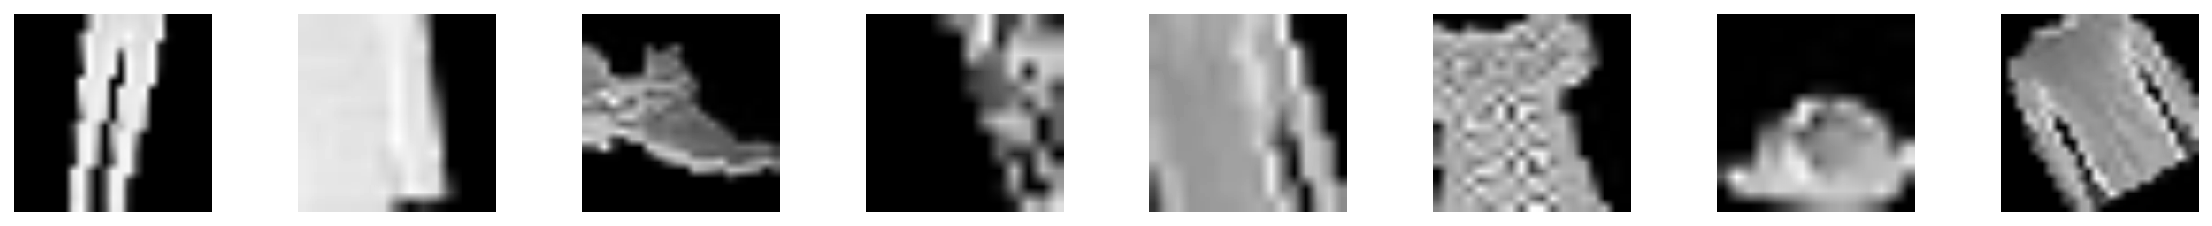

In [42]:
# Visualize data

import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(8):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    # ax.set_title(str(labels[idx].item()))


In [54]:
from torch.optim import lr_scheduler
model = Network()
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#move tensor to default device
model.to(device)

Network(
  (layer1): Linear(in_features=50176, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=128, bias=True)
  (layer4): Linear(in_features=128, out_features=128, bias=True)
  (layer5): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)

In [0]:
model.load_state_dict(torch.load('mode.pth'))

In [56]:
# Train model
epoch = 10

# compare overfited
train_loss_data,valid_loss_data = [],[]

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for e in range(epoch):
  # monitor training loss
  train_loss = 0.0
  valid_loss = 0.0
  
  # train model
  model.train()
  # step scheduler
  scheduler.step()
  
  
  for images,labels in train_loader:
    # Move input and label tensors to the default device
    images, labels = images.to(device), labels.to(device)
    # clear the gradients
    optimizer.zero_grad()
    # forward pass: compute predicted outputs by passing inputs to the model
    log_ps = model(images)
    # calculate the loss
    loss = criterion(log_ps,labels)
    # backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    # perform a single optimization step (parameter update)
    optimizer.step()
    # update the running loss
    train_loss += loss.item() * images.size(0)
    
    
  ####################
  # validate the model
  ####################
  
  with torch.no_grad():
    # set the model in evaluation mode
    model.eval()
    for images,labels in train_loader:
      # Move input and label tensors to the default device
      images, labels = images.to(device), labels.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      log_ps = model(images)
      # calculate the loss
      loss = criterion(log_ps,labels)
      # update the running loss
      valid_loss += loss.item()*images.size(0)
    
    
  # print training/validation statistics 
  # calculate average loss over an epoch
  train_loss = (train_loss/len(train_loader.dataset)) * 100
  valid_loss = (valid_loss/len(valid_loader.dataset)) * 100
  #clculate train loss and running loss
  train_loss_data.append(train_loss)
  valid_loss_data.append(valid_loss)
  
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e+1, 
        train_loss,
        valid_loss))
  
  if valid_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min, valid_loss))
    name = "model{}.pth".format(e+1)
    torch.save(model.state_dict(), "model.pth")
    valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 140.054227 	Validation Loss: 123.939952
Validation loss decreased (inf --> 123.939952).  Saving model ...
Epoch: 2 	Training Loss: 126.014965 	Validation Loss: 120.676426
Validation loss decreased (123.939952 --> 120.676426).  Saving model ...
Epoch: 3 	Training Loss: 123.805842 	Validation Loss: 116.918976
Validation loss decreased (120.676426 --> 116.918976).  Saving model ...
Epoch: 4 	Training Loss: 122.159227 	Validation Loss: 112.564076
Validation loss decreased (116.918976 --> 112.564076).  Saving model ...
Epoch: 5 	Training Loss: 120.799295 	Validation Loss: 110.931028
Validation loss decreased (112.564076 --> 110.931028).  Saving model ...
Epoch: 6 	Training Loss: 110.495051 	Validation Loss: 101.573824
Validation loss decreased (110.931028 --> 101.573824).  Saving model ...
Epoch: 7 	Training Loss: 108.323215 	Validation Loss: 99.982499
Validation loss decreased (101.573824 --> 99.982499).  Saving model ...
Epoch: 8 	Training Loss: 105.972181 	Valida

In [0]:
# load the saved model
model.load_state_dict(torch.load('model.pth'))

# 45 89%

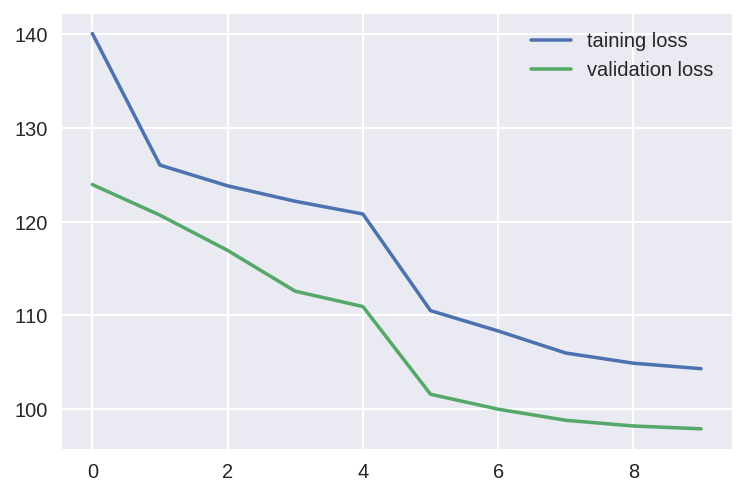

In [57]:
# check for overfitting
plt.plot(train_loss_data, label = "taining loss")
plt.plot(valid_loss_data, label = "validation loss")
plt.legend(frameon = False)

In [58]:
# initialize lists to monitor test loss and accuracy
test_loss = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  model.eval() # prep model for evaluation
  for data, target in test_loader:
      # Move input and label tensors to the default device
      data, target = data.to(device), target.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data)
      # calculate the loss
      loss = criterion(output, target)
      # update test loss 
      test_loss += loss.item() #*data.size(0)
      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)
      # compare predictions to true label
      correct = np.squeeze(pred.eq(target.data.view_as(pred)))
      # calculate test accuracy for each object class
      for i in range(16):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1
  
  # calculate and print avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))
  
  for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.061197

Test Accuracy of     0: 53% (427/795)
Test Accuracy of     1: 77% (614/791)
Test Accuracy of     2: 57% (456/800)
Test Accuracy of     3: 58% (468/806)
Test Accuracy of     4: 36% (287/797)
Test Accuracy of     5: 69% (554/794)
Test Accuracy of     6:  4% (38/808)
Test Accuracy of     7: 65% (531/816)
Test Accuracy of     8: 66% (536/807)
Test Accuracy of     9: 55% (437/786)

Test Accuracy (Overall): 54% (4348/8000)


In [0]:
import helper

# send pic to model
model.eval()
model.to(device)

data,target = next(iter(train_loader))
data, target = data.to(device), target.to(device)

# take single img
img = data[0]
# conver to 1D
img = img.view(1,784)

with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)
helper.view_classify(img.view(1,28,28),ps,version='Fashion')

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

model_save_name = 'classifier.pt'
path = "/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)